In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import warnings
from IPython.display import IFrame
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
from tensorflow import keras
from sklearn.model_selection import cross_val_score

%matplotlib inline
warnings.filterwarnings('ignore')

df = pd.read_excel("../data/info_satisfaccion_trabajo.xlsx")
df.head(3)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0


# __EDA with pandas_profiling__ 

[EDA with pandas_profiling](https://davidcamilo0710.github.io/Coink)


In [2]:
# # Generate report using pandas-profiling
# report = df.profile_report()

# # Save the report to an HTML file
# report.to_file("report.html")

# # View the report in the notebook
# IFrame(src='report.html', width=1000, height=600)

The report shows that the dataset contains 1470 observations and 35 variables, with 15 being numeric, 3 boolean, and 17 categorical. No missing cells or duplicate rows were found in the dataset.

The Alerts highlight some important characteristics of the dataset, including the presence of constant variables (EmployeeCount, Over18, StandardHours), and high correlations between several numeric variables, such as Age with TotalWorkingYears, MonthlyIncome with TotalWorkingYears and one other variable, PercentSalaryHike with PerformanceRating, among others. There is also high correlation between categorical variables like Department and EducationField, and JobRole and Department.

Overall, the pandas_profiling report provides valuable information about the dataset characteristics, including the distribution and type of variables, as well as relationships and correlations between them. It also detects constant variables and missing or zero values. This information will be useful for developing the requested supervised learning models and save some time.

### Resumamos el dataset

In [3]:
def dataframe_summary(df):
    # Number of rows and columns
    summary = []
    summary.append(["Number of rows and columns:", f"{df.shape[0]} rows, {df.shape[1]} columns"])
    
    # Number of null values
    null_counts = df.isnull().sum()
    if null_counts.sum() > 0:
        null_cols = null_counts[null_counts > 0]
        summary.append(["Number of null values:", f"{null_counts.sum()} in total across {len(null_cols)} columns"])
    else :
        summary.append(["Number of null values:", "None"])
        
    # Number of duplicates
    num_duplicates = df.duplicated().sum()
    if num_duplicates > 0:
        summary.append(["Number of duplicates:", f"{num_duplicates}"])
    else:
        summary.append(["Number of duplicates:", "None"])
    
    # Columns with many outliers
    outlier_threshold = 3
    outliers_summary = []
    for col in df.select_dtypes(include=np.number).columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        interquartile_range = q3 - q1
        outliers = ((df[col] < q1 - outlier_threshold*interquartile_range) | (df[col] > q3 + outlier_threshold*interquartile_range))
        outlier_percentage = outliers.sum()/df.shape[0]
        if outlier_percentage > 0.05:
            outliers_summary.append([col, f"{outlier_percentage:.2%}"])
    
    if outliers_summary:
        summary.append(["Columns with many outliers:", ""])
        summary.extend(outliers_summary)
        summary.append(["", ""])
    
    # Imbalanced columns
    imbalanced_summary = []
    for col in df.select_dtypes(include=["object", "category"]).columns:
        if df[col].nunique() > 2:
            value_counts = df[col].value_counts(normalize=True)
            if (value_counts < 0.05).any():
                imbalanced_summary.append([col, ""])
    
    if imbalanced_summary:
        summary.append(["Imbalanced categorical columns:", ""])
        summary.extend(imbalanced_summary)
        summary.append(["", ""])
    
    # Categorical columns that need encoding
    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    cat_cols_to_encode = [col for col in cat_cols if len(df[col].value_counts()) > 2]
    if cat_cols_to_encode:
        summary.append(["Categorical columns that need encoding for ML:", ""])
        summary.append([", ".join(cat_cols_to_encode), ""])
        summary.append(["", ""])
    else:
        summary.append(["All categorical columns are encoded for ML.", ""])
        summary.append(["", ""])
    
    # Binary columns that need encoding
    binary_cols = [col for col in df.columns if len(df[col].value_counts()) == 2]
    binary_cols_to_encode = [col for col in binary_cols if df[col].dtype == "object" or df[col].dtype.name == "category"]
    if binary_cols_to_encode:
        summary.append(["Boolean columns that need encoding for ML:", ""])
        summary.append([", ".join(binary_cols_to_encode), ""])
        summary.append(["", ""])
    else:
        summary.append(["All boolean columns are encoded for ML.", ""])
        summary.append(["", ""])
    
    # Columns with only one unique value
    single_value_cols = [col for col in df.columns if len(df[col].value_counts()) == 1]
    if single_value_cols:
        summary.append(["Columns with only one unique value:", ""])
        summary.append([", ".join(single_value_cols), ""])
    
    # Print summary table
    print(tabulate(summary, headers=["Issue", "Details"], tablefmt="pretty"))

dataframe_summary(df)

+--------------------------------------------------------------------+-----------------------+
|                               Issue                                |        Details        |
+--------------------------------------------------------------------+-----------------------+
|                    Number of rows and columns:                     | 1470 rows, 35 columns |
|                       Number of null values:                       |         None          |
|                       Number of duplicates:                        |         None          |
|                    Columns with many outliers:                     |                       |
|                         PerformanceRating                          |        15.37%         |
|                                                                    |                       |
|                  Imbalanced categorical columns:                   |                       |
|                             Department          

In [4]:
# Drop the specified columns
df.drop(columns=["EmployeeCount", "Over18", "StandardHours"], inplace=True)

# Replace "True" and "False" with 1 and 0 in Attrition and OverTime columns
df["Attrition"] = df["Attrition"].replace({"Yes": 1, "No": 0})
df["OverTime"] = df["OverTime"].replace({"Yes": 1, "No": 0})

# Replace "Male" and "Female" with 0 and 1 in Gender column
df["Gender"] = df["Gender"].replace({"Male": 0, "Female": 1})

# Apply one-hot encoding to categorical variables
categorical_columns = ["BusinessTravel", "Department", "EducationField", "JobRole", "MaritalStatus"]
encoder = OneHotEncoder(sparse=False, drop="first")
encoded_columns = encoder.fit_transform(df[categorical_columns])
categories = encoder.categories_
encoded_columns_df = pd.DataFrame(encoded_columns, columns=[f"{col}_{val}" for col, cats in zip(categorical_columns, categories) for val in cats[1:]])
df.drop(columns=categorical_columns, inplace=True)
df = pd.concat([df, encoded_columns_df], axis=1)
df_bandera = df.copy()

# Print the preprocessed dataset
df.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1102,1,2,1,2,1,94,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,49,0,279,8,1,2,3,0,61,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,1,1373,2,2,4,4,0,92,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,33,0,1392,3,4,5,4,1,56,3,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,27,0,591,2,1,7,1,0,40,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
# Separar dataset en entrenamiento y test
X = df.drop(columns=["JobSatisfaction"])
y = df["JobSatisfaction"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Definir modelos y parámetros
clf_rf = RandomForestClassifier()
clf_svm = SVC()
clf_gb = GradientBoostingClassifier()
clf_ann = MLPClassifier()

# Entrenar modelos
clf_rf.fit(X_train, y_train)
clf_svm.fit(X_train, y_train)
clf_gb.fit(X_train, y_train)
clf_ann.fit(X_train, y_train)

# Realizar predicciones en conjunto de prueba y evaluar métricas
y_pred_rf = clf_rf.predict(X_test)
y_pred_svm = clf_svm.predict(X_test)
y_pred_gb = clf_gb.predict(X_test)
y_pred_ann = clf_ann.predict(X_test)

# Evaluar métricas

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, average="weighted")
rec_rf = recall_score(y_test, y_pred_rf, average="weighted")
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")

acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm, average="weighted")
rec_svm = recall_score(y_test, y_pred_svm, average="weighted")
f1_svm = f1_score(y_test, y_pred_svm, average="weighted")

acc_gb = accuracy_score(y_test, y_pred_gb)
prec_gb = precision_score(y_test, y_pred_gb, average="weighted")
rec_gb = recall_score(y_test, y_pred_gb, average="weighted")
f1_gb = f1_score(y_test, y_pred_gb, average="weighted")

acc_ann = accuracy_score(y_test, y_pred_ann)
prec_ann = precision_score(y_test, y_pred_ann, average="weighted")
rec_ann = recall_score(y_test, y_pred_ann, average="weighted")
f1_ann = f1_score(y_test, y_pred_ann, average="weighted")

In [6]:
# Formateamos los datos de los modelos de clasificación en forma de lista
data_classification = [
    ["Random Forest Classifier:", f"{acc_rf:.4f}", f"{prec_rf:.4f}", f"{rec_rf:.4f}", f"{f1_rf:.4f}"],
    ["Support Vector Machine Classifier:", f"{acc_svm:.4f}", f"{prec_svm:.4f}", f"{rec_svm:.4f}", f"{f1_svm:.4f}"],
    ["Gradient Boosting Classifier:", f"{acc_gb:.4f}", f"{prec_gb:.4f}", f"{rec_gb:.4f}", f"{f1_gb:.4f}"],
    ["Artificial Neural Network Classifier:", f"{acc_ann:.4f}", f"{prec_ann:.4f}", f"{rec_ann:.4f}", f"{f1_ann:.4f}"]
]

# Imprimimos la tabla para modelos de clasificación
print(tabulate(data_classification, headers=["Model", "Accuracy", "Precision", "Recall", "F1-Score"], tablefmt="pretty"))

+---------------------------------------+----------+-----------+--------+----------+
|                 Model                 | Accuracy | Precision | Recall | F1-Score |
+---------------------------------------+----------+-----------+--------+----------+
|       Random Forest Classifier:       |  0.2483  |  0.2114   | 0.2483 |  0.2173  |
|  Support Vector Machine Classifier:   |  0.3231  |  0.2130   | 0.3231 |  0.2244  |
|     Gradient Boosting Classifier:     |  0.2687  |  0.2518   | 0.2687 |  0.2507  |
| Artificial Neural Network Classifier: |  0.2687  |  0.1478   | 0.2687 |  0.1896  |
+---------------------------------------+----------+-----------+--------+----------+


In [7]:
# Definir diccionario de mapeo
mapping = {1: 0, 2: 0, 3: 1, 4: 1}

# Aplicar mapeo a los datos de entrenamiento y prueba
y_train = y_train.map(mapping)
y_test = y_test.map(mapping)

# Definir modelos y parámetros
clf_rf = RandomForestClassifier()
clf_svm = SVC()
clf_gb = GradientBoostingClassifier()
clf_ann = MLPClassifier()
clf_knn = KNeighborsClassifier()
clf_lr = LogisticRegression()
clf_dt = DecisionTreeClassifier()
clf_xgb = XGBClassifier()


model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(45,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Entrenar modelos
clf_rf.fit(X_train, y_train)
clf_svm.fit(X_train, y_train)
clf_gb.fit(X_train, y_train)
clf_ann.fit(X_train, y_train)
clf_knn.fit(X_train, y_train)
clf_lr.fit(X_train, y_train)
clf_dt.fit(X_train, y_train)
clf_xgb.fit(X_train, y_train)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2, validation_data=(X_test, y_test), verbose=0)

# Realizar predicciones en conjunto de prueba y evaluar métricas
y_pred_rf = clf_rf.predict(X_test)
y_pred_svm = clf_svm.predict(X_test)
y_pred_gb = clf_gb.predict(X_test)
y_pred_ann = clf_ann.predict(X_test)
y_pred_knn = clf_knn.predict(X_test)
y_pred_lr = clf_lr.predict(X_test)
y_pred_dt = clf_dt.predict(X_test)
y_pred_xgb = clf_xgb.predict(X_test)
y_pred_keras = model.predict(X_test)
y_pred_keras = [1 if pred > 0.5 else 0 for pred in y_pred_keras]

# Evaluar métricas

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, average="weighted")
rec_rf = recall_score(y_test, y_pred_rf, average="weighted")
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(y_test, y_pred_rf).ravel()
tpr_rf = tp_rf / (tp_rf + fn_rf)
fpr_rf = fp_rf / (fp_rf + tn_rf)
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)

acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm, average="weighted")
rec_svm = recall_score(y_test, y_pred_svm, average="weighted")
f1_svm = f1_score(y_test, y_pred_svm, average="weighted")
tn_svm, fp_svm, fn_svm, tp_svm = confusion_matrix(y_test, y_pred_svm).ravel()
tpr_svm = tp_svm / (tp_svm + fn_svm)
fpr_svm = fp_svm / (fp_svm + tn_svm)
mcc_svm = matthews_corrcoef(y_test, y_pred_svm)

acc_gb = accuracy_score(y_test, y_pred_gb)
prec_gb = precision_score(y_test, y_pred_gb, average="weighted")
rec_gb = recall_score(y_test, y_pred_gb, average="weighted")
f1_gb = f1_score(y_test, y_pred_gb, average="weighted")
tn_gb, fp_gb, fn_gb, tp_gb = confusion_matrix(y_test, y_pred_gb).ravel()
tpr_gb = tp_gb / (tp_gb + fn_gb)
fpr_gb = fp_gb / (fp_gb + tn_gb)
mcc_gb = matthews_corrcoef(y_test, y_pred_gb)

acc_ann = accuracy_score(y_test, y_pred_ann)
prec_ann = precision_score(y_test, y_pred_ann, average="weighted")
rec_ann = recall_score(y_test, y_pred_ann, average="weighted")
f1_ann = f1_score(y_test, y_pred_ann, average="weighted")
tn_ann, fp_ann, fn_ann, tp_ann = confusion_matrix(y_test, y_pred_ann).ravel()
tpr_ann = tp_ann / (tp_ann + fn_ann)
fpr_ann = fp_ann / (fp_ann + tn_ann)
mcc_ann = matthews_corrcoef(y_test, y_pred_ann)

acc_knn = accuracy_score(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn, average="weighted")
rec_knn = recall_score(y_test, y_pred_knn, average="weighted")
f1_knn = f1_score(y_test, y_pred_knn, average="weighted")
tn_knn, fp_knn, fn_knn, tp_knn = confusion_matrix(y_test, y_pred_knn).ravel()
tpr_knn = tp_knn / (tp_knn + fn_knn)
fpr_knn = fp_knn / (fp_knn + tn_knn)
mcc_knn = matthews_corrcoef(y_test, y_pred_knn)

acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr, average="weighted")
rec_lr = recall_score(y_test, y_pred_lr, average="weighted")
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
tn_lr, fp_lr, fn_lr, tp_lr = confusion_matrix(y_test, y_pred_lr).ravel()
tpr_lr = tp_lr / (tp_lr + fn_lr)
fpr_lr = fp_lr / (fp_lr + tn_lr)
mcc_lr = matthews_corrcoef(y_test, y_pred_lr)

acc_dt = accuracy_score(y_test, y_pred_dt)
prec_dt = precision_score(y_test, y_pred_dt, average="weighted")
rec_dt = recall_score(y_test, y_pred_dt, average="weighted")
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
tn_dt, fp_dt, fn_dt, tp_dt = confusion_matrix(y_test, y_pred_dt).ravel()
tpr_dt = tp_dt / (tp_dt + fn_dt)
fpr_dt = fp_dt / (fp_dt + tn_dt)
mcc_dt = matthews_corrcoef(y_test, y_pred_dt)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb, average="weighted")
rec_xgb = recall_score(y_test, y_pred_xgb, average="weighted")
f1_xgb = f1_score(y_test, y_pred_xgb, average="weighted")
tn_xgb, fp_xgb, fn_xgb, tp_xgb = confusion_matrix(y_test, y_pred_xgb).ravel()
tpr_xgb = tp_xgb / (tp_xgb + fn_xgb)
fpr_xgb = fp_xgb / (fp_xgb + tn_xgb)
mcc_xgb = matthews_corrcoef(y_test, y_pred_xgb)
    
acc_nn = accuracy_score(y_test, y_pred_keras)
prec_nn = precision_score(y_test, y_pred_keras)
rec_nn = recall_score(y_test, y_pred_keras)
f1_nn = f1_score(y_test, y_pred_keras)
tn_nn, fp_nn, fn_nn, tp_nn = confusion_matrix(y_test, y_pred_keras).ravel()
tpr_nn = tp_nn / (tp_nn + fn_nn)
fpr_nn = fp_nn / (fp_nn + tn_nn)
mcc_nn = matthews_corrcoef(y_test, y_pred_keras)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-26 19:52:28.466062: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-26 19:52:28.466174: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-26 19:52:30.334651: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-26 19:52:30.628998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-26 19:52:31.176334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 8ms/step


2023-02-26 19:52:46.827709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [8]:
# Formateamos los datos de los modelos de clasificación en forma de lista
data_classification = [
    ["Random Forest Classifier:", f"{acc_rf:.4f}", f"{prec_rf:.4f}", f"{rec_rf:.4f}", f"{f1_rf:.4f}", f"{tpr_rf:.4f}", f"{fpr_rf:.4f}", f"{mcc_rf:.4f}"],
    ["Support Vector Machine Classifier:", f"{acc_svm:.4f}", f"{prec_svm:.4f}", f"{rec_svm:.4f}", f"{f1_svm:.4f}", f"{tpr_svm:.4f}", f"{fpr_svm:.4f}", f"{mcc_svm:.4f}"],
    ["Gradient Boosting Classifier:", f"{acc_gb:.4f}", f"{prec_gb:.4f}", f"{rec_gb:.4f}", f"{f1_gb:.4f}", f"{tpr_gb:.4f}", f"{fpr_gb:.4f}", f"{mcc_gb:.4f}"],
    ["Artificial Neural Network Classifier:", f"{acc_ann:.4f}", f"{prec_ann:.4f}", f"{rec_ann:.4f}", f"{f1_ann:.4f}", f"{tpr_ann:.4f}", f"{fpr_ann:.4f}", f"{mcc_ann:.4f}"],
    ["K-Nearest Neighbors Classifier:", f"{acc_knn:.4f}", f"{prec_knn:.4f}", f"{rec_knn:.4f}", f"{f1_knn:.4f}", f"{tpr_knn:.4f}", f"{fpr_knn:.4f}", f"{mcc_knn:.4f}"],
    ["Logistic Regression Classifier:", f"{acc_lr:.4f}", f"{prec_lr:.4f}", f"{rec_lr:.4f}", f"{f1_lr:.4f}", f"{tpr_lr:.4f}", f"{fpr_lr:.4f}", f"{mcc_lr:.4f}"],
    ["Decision Tree Classifier:", f"{acc_dt:.4f}", f"{prec_dt:.4f}", f"{rec_dt:.4f}", f"{f1_dt:.4f}", f"{tpr_dt:.4f}", f"{fpr_dt:.4f}", f"{mcc_dt:.4f}"],
    ["XGBoost Classifier:", f"{acc_xgb:.4f}", f"{prec_xgb:.4f}", f"{rec_xgb:.4f}", f"{f1_xgb:.4f}", f"{tpr_xgb:.4f}", f"{fpr_xgb:.4f}", f"{mcc_xgb:.4f}"],
    ["Keras Neural Network:", f"{acc_nn:.4f}", f"{prec_nn:.4f}", f"{rec_nn:.4f}", f"{f1_nn:.4f}", f"{tpr_nn:.4f}", f"{fpr_nn:.4f}", f"{mcc_nn:.4f}"]
]

# Imprimimos la tabla para modelos de clasificación
print(tabulate(data_classification, headers=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "TPR", "FPR", "MCC"], tablefmt="pretty"))

+---------------------------------------+----------+-----------+--------+----------+--------+--------+---------+
|                 Model                 | Accuracy | Precision | Recall | F1-Score |  TPR   |  FPR   |   MCC   |
+---------------------------------------+----------+-----------+--------+----------+--------+--------+---------+
|       Random Forest Classifier:       |  0.6020  |  0.5482   | 0.6020 |  0.5344  | 0.8852 | 0.8649 | 0.0301  |
|  Support Vector Machine Classifier:   |  0.6224  |  0.3874   | 0.6224 |  0.4776  | 1.0000 | 1.0000 | 0.0000  |
|     Gradient Boosting Classifier:     |  0.6327  |  0.6068   | 0.6327 |  0.5881  | 0.8743 | 0.7658 | 0.1412  |
| Artificial Neural Network Classifier: |  0.5884  |  0.4650   | 0.5884 |  0.4818  | 0.9235 | 0.9640 | -0.0818 |
|    K-Nearest Neighbors Classifier:    |  0.5170  |  0.4965   | 0.5170 |  0.5041  | 0.6721 | 0.7387 | -0.0703 |
|    Logistic Regression Classifier:    |  0.6088  |  0.4476   | 0.6088 |  0.4769  | 0.9727 | 0.

In [9]:
# Realizar validación cruzada y obtener puntajes MCC
n_repeats = 5
scoring = 'matthews_corrcoef'
cv_rf = cross_val_score(clf_rf, X_test, y_test, cv=n_repeats, scoring=scoring)
cv_svm = cross_val_score(clf_rf, X_test, y_test, cv=n_repeats, scoring=scoring)
cv_gb = cross_val_score(clf_rf, X_test, y_test, cv=n_repeats, scoring=scoring)
cv_ann = cross_val_score(clf_rf, X_test, y_test, cv=n_repeats, scoring=scoring)
cv_knn = cross_val_score(clf_rf, X_test, y_test, cv=n_repeats, scoring=scoring)
cv_lr = cross_val_score(clf_rf, X_test, y_test, cv=n_repeats, scoring=scoring)
cv_dt = cross_val_score(clf_rf, X_test, y_test, cv=n_repeats, scoring=scoring)
cv_xgb = cross_val_score(clf_rf, X_test, y_test, cv=n_repeats, scoring=scoring)

cv_keras = []
for i in range(n_repeats):
    model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2, verbose=0)
    y_pred_keras = model.predict(X_test)
    y_pred_keras = [1 if pred > 0.5 else 0 for pred in y_pred_keras]
    cv_keras.append(matthews_corrcoef(y_test, y_pred_keras))

# Imprimir resultados de validación cruzada
results = [    ["Random Forest", cv_rf.mean(), cv_rf.std()],
    ["SVM", cv_svm.mean(), cv_svm.std()],
    ["Gradient Boosting", cv_gb.mean(), cv_gb.std()],
    ["Artificial Neural Network", np.mean(cv_ann), np.std(cv_ann)],
    ["K-Nearest Neighbors", np.mean(cv_knn), np.std(cv_knn)],
    ["Logistic Regression", np.mean(cv_lr), np.std(cv_lr)],
    ["Decision Tree", np.mean(cv_dt), np.std(cv_dt)],
    ["XGBoost", np.mean(cv_xgb), np.std(cv_xgb)],
    ["Keras Neural Network", np.mean(cv_keras), np.std(cv_keras)]
]

headers = ["Model", "MCC", "Std"]
print(tabulate(results, headers=headers, tablefmt="pretty"))


10/10 [==============================] - 0s 2ms/step
+---------------------------+-----------------------+----------------------+
|           Model           |          MCC          |         Std          |
+---------------------------+-----------------------+----------------------+
|       Random Forest       | -0.06509465257452537  | 0.12910231045774126  |
|            SVM            | -0.05796871706631841  | 0.06454999540760914  |
|     Gradient Boosting     | -0.06339657993734892  | 0.12753453645966817  |
| Artificial Neural Network | -0.08671840213306475  |  0.138845105215483   |
|    K-Nearest Neighbors    | -0.009275641555586077 | 0.11493482302742605  |
|    Logistic Regression    | 0.0050696055839992695 | 0.11298034635373323  |
|       Decision Tree       |  -0.0320026152259031  | 0.07979488301305451  |
|          XGBoost          | -0.030550738917391594 | 0.08610618008061757  |
|   Keras Neural Network    | 0.004903187463190421  | 0.009806374926380841 |
+----------------------

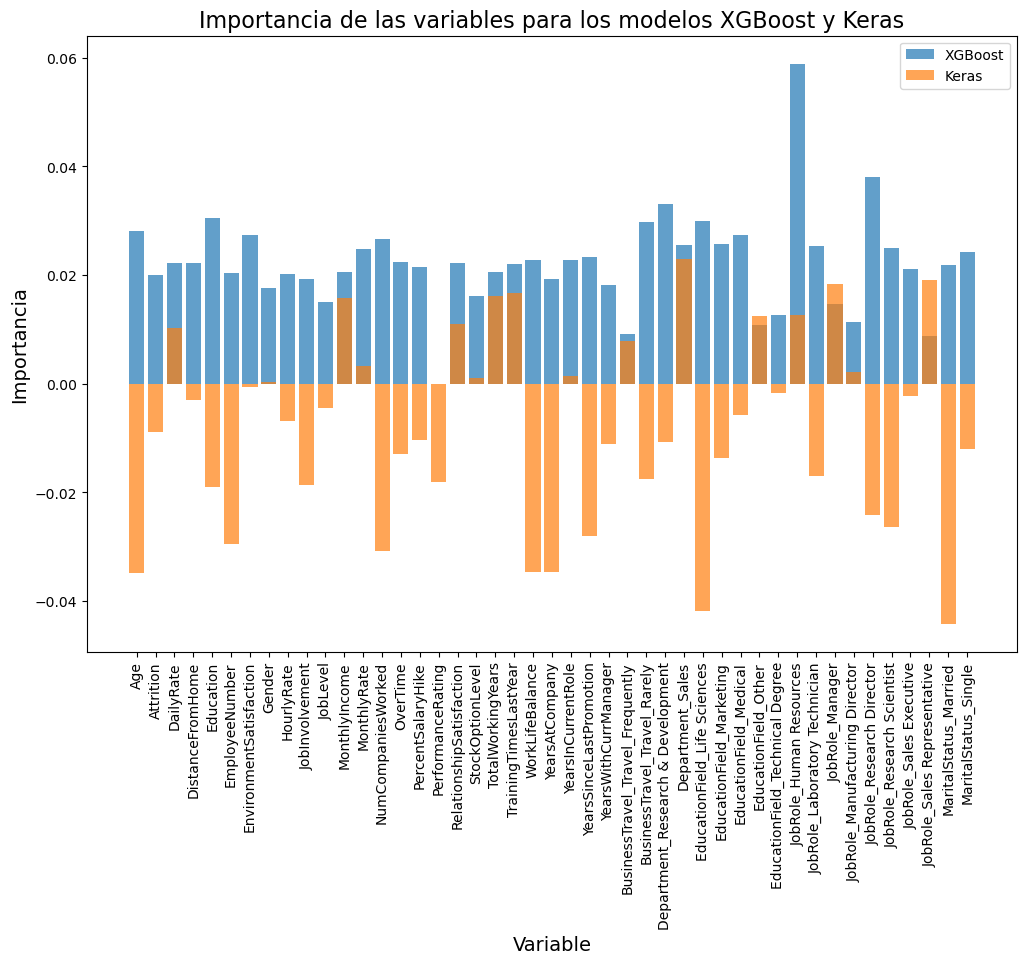

In [10]:
# Obtener importancia de las variables del modelo XGBoost
xgb_importances = clf_xgb.feature_importances_

# Obtener importancia de las variables del modelo Keras
keras_importances = model.layers[0].get_weights()[0].mean(axis=1)

# Crear un DataFrame con las importancias
importances = pd.DataFrame({
    'Variable': df_bandera.drop(columns=['JobSatisfaction']).columns,
    'XGBoost': xgb_importances,
    'Keras': keras_importances
})

# Establecer la variable como índice
importances.set_index('Variable', inplace=True)

# Crear una figura y definir su tamaño
fig, ax = plt.subplots(figsize=(12, 8))

# Crear las barras de las importancias de cada modelo
ax.bar(importances.index, importances['XGBoost'], color='#1f77b4', alpha=0.7, label='XGBoost')
ax.bar(importances.index, importances['Keras'], color='#ff7f0e', alpha=0.7, label='Keras')

# Establecer el título y etiquetas de los ejes
ax.set_title('Importancia de las variables para los modelos XGBoost y Keras', fontsize=16)
ax.set_xlabel('Variable', fontsize=14)
ax.set_ylabel('Importancia', fontsize=14)

# Rotar los nombres de las variables en el eje x
plt.xticks(rotation=90)

# Agregar leyenda
ax.legend()

# Mostrar la gráfica
plt.show()



In [11]:
import pandas as pd

# Crear una lista de columnas a eliminar basado en las importancias de XGBoost
xgb_importances = clf_xgb.feature_importances_
xgb_threshold = 0.02

xgb_drop_cols = [col for col, imp in zip(df_bandera.columns, xgb_importances) if abs(imp) < abs(xgb_threshold)]

# Crear una lista de columnas a eliminar basado en las importancias de Keras
keras_importances = model.layers[0].get_weights()[0].mean(axis=1)
keras_threshold = 0.01

keras_drop_cols = [col for col, imp in zip(df_bandera.columns, keras_importances) if abs(imp) < abs(keras_threshold)]

# Crear un nuevo dataframe para XGBoost
df_xgb = df_bandera.drop(xgb_drop_cols, axis=1)

# Crear un nuevo dataframe para Keras
df_keras = df_bandera.drop(keras_drop_cols, axis=1)

# Opcionalmente, imprimir las columnas eliminadas para cada dataframe
print("Columnas eliminadas para XGBoost:", xgb_drop_cols)
print("Columnas eliminadas para Keras:", keras_drop_cols)


Columnas eliminadas para XGBoost: ['Gender', 'JobInvolvement', 'JobLevel', 'PercentSalaryHike', 'RelationshipSatisfaction', 'WorkLifeBalance', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'EducationField_Medical', 'EducationField_Other', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Sales Executive']
Columnas eliminadas para Keras: ['Attrition', 'DistanceFromHome', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobLevel', 'MonthlyIncome', 'RelationshipSatisfaction', 'YearsAtCompany', 'YearsWithCurrManager', 'EducationField_Marketing', 'EducationField_Other', 'JobRole_Manager', 'JobRole_Research Scientist']


In [18]:
print("Número de columnas en el dataframe Keras: {}".format(df_keras.shape[1]))
print("Número de columnas en el dataframe XGBoost: {}".format(df_keras.shape[1])  )

Número de columnas en el dataframe original: 32
